<a href="https://colab.research.google.com/github/HwangJae-won/Hands-on-machine-learning/blob/main/ch2_End_to_end_ML_(California_Housing_Prices_modeling).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.  사용 데이터 및 문제 정의 

## 1. 사용 데이터 
- 캘리포니아 주택 가격(California Housing Prices) 데이터셋: 1990년 캘리포니아 인구조사 데이터를 기반으로 만들어진 데이터

- 캘리포니아의 블록 그룹(block group)마다 인구(population), 중간 소득(median income), 중간 주택 가격(median housing price)

- 데이터에 대한 세부 설명: https://developers.google.com/machine-learning/crash-course/california-housing-data-description?hl=ko  

## 2. 문제 정의
캘리포니아 주택 가격 데이터셋을 가지고 학습시켜 다른 데이터가 주어졌을 때 구역의 주택 가격의 median을 예측하는 모델 만들기 


## 3. 성능 측정 지표 
MSE 사용

# 2. set up option & DATA loading

In [9]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"


# 일관된 출력을 위해 유사난수 초기화
np.random.seed(42)

In [8]:
import os
import pandas as pd
import numpy as np


#시각화 옵션
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
#차트 기본 크기 설정
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

# 한글출력
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

In [5]:
# 이미지 저장 루트
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True) #이미지 디렉토리 생성
os.listdir() #디렉토리 확인

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


In [3]:
#동시 출력 가능 코드 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity="all"

# 경고 무시
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Load the data

In [10]:
import tarfile
import urllib.request #인터넷에서 데이터 불러오는 모듈

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz" #데이터 다운로드됨

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [12]:
fetch_housing_data()

In [13]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)
housing = load_housing_data()
housing.head(3)
#median_house_value: 예측하고자하는 주택 가격의 median

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY


In [14]:
housing.info()
housing.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


- missing value in 'total_bedrooms'   
- dtype of 'ocean_proximity' is object: maybe it need one-hot encoding

# 3. EDA 

## 1. split data

자세한 EDA 진행하기 전에 test set 분리해두기: 데이터 스누핑 방지 (test set으로 EDA 진행하면 overfitting되는 모델 선택할 수도 있음)

<계층적 샘플링>

- 표본의 수가 충분하지 않을 경우 편향 발생 가능
- Train/Test set이 각 데이터를 대표할 수 있도록 고르게 샘플링 되기 위해서 사용, 전체 모수를 계층으로 나눠 각 계층마다 샘플링을 하는 방법
- 모집단의 데이터 분포 비율을 유지하면서 데이터를 샘플링

캘리포니아 주택 가격 데이터 셋에서 전문가가 주택 가격의 median을 예측하는데에 소득의 median이 영향을 준다고 이야기했다고 가정:이를 기준으로 계층적 샘플링 진행 (분석을 위해 데이터에 대한 사전 조사가 필요한 이유!)

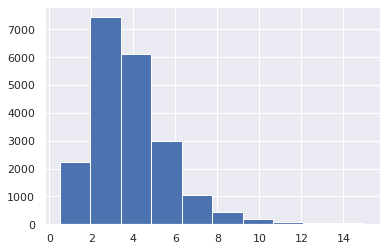

In [ ]:
housing['median_income'].hist();

계층적 샘플링을 위해서는 계층별로 충분한 수의 샘플 필요. 현재 구간별 데이터 수의 차이가 심하므로 pd.cut(동일 길이로 나누어 범주 만들기 )

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

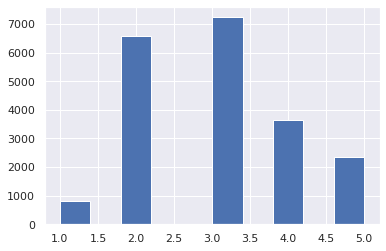

In [ ]:
housing["income_cat"] = pd.cut(housing["median_income"],
                             
                            bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5]) #5개의 카테고리를 가진 소득 카테고리 특성 생성
housing["income_cat"].value_counts()/ len(housing)

#구간 나눠진 것 확인
housing["income_cat"].hist()

In [ ]:
#계층적 샘플링
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=43)


for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [ ]:
strat_test_set.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,income_cat
5057,-118.35,34.02,27.0,3358.0,1069.0,2415.0,956.0,1.4589,87500.0,1
6954,-118.06,33.98,40.0,1410.0,255.0,932.0,273.0,4.2206,178000.0,3
16876,-122.40,37.60,30.0,5351.0,1134.0,2558.0,1074.0,3.5817,369300.0,3


In [ ]:
#분석에 필요없는 열 삭제 #income_cat은 계층별 비율 확인하기 위해 추가해준 열
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

strat_test_set.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
5057,-118.35,34.02,27.0,3358.0,1069.0,2415.0,956.0,1.4589,87500.0
6954,-118.06,33.98,40.0,1410.0,255.0,932.0,273.0,4.2206,178000.0
16876,-122.40,37.60,30.0,5351.0,1134.0,2558.0,1074.0,3.5817,369300.0


## 2. data exploration

### 1. 데이터 구조 확인

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f77eaf8f9d0>,
      dtype=object)

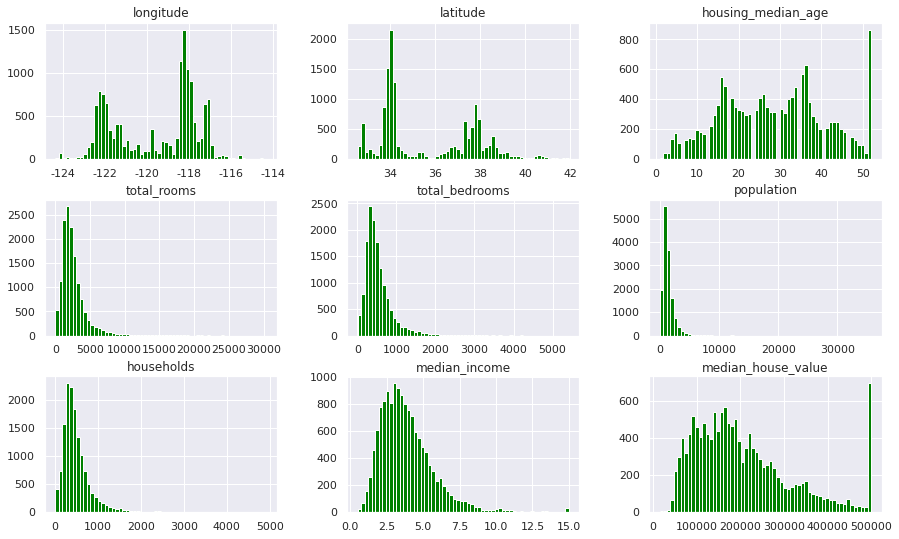

In [ ]:
strat_train_set.hist(bins=60, figsize=(15, 9), color="green"); plt.show()

확인할 수 있는 점

- 다른 특성과 달리 median_income 은 스케일링되어 있음 
- housing_median_age와 housing_median_value은 outlier 존재 : 분석 위해 제거해줄 필요 있음.
- 특성들의 단위가 다름: 스케일링 필요


### 2. 지리적 데이터 시각화

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44221 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0, flags=flags)
/u

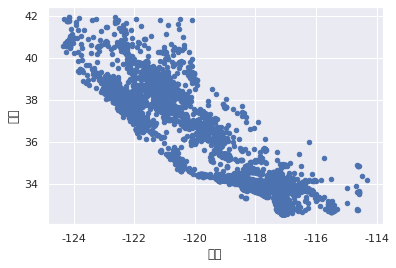

In [ ]:
ax = strat_train_set.plot(kind='scatter', x='longitude', y='latitude')
ax.set(xlabel='경도', ylabel='위도');

특별한 인사이트 없음

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


[Text(0, 0.5, 'latitude'), Text(0.5, 0, 'longitude')]

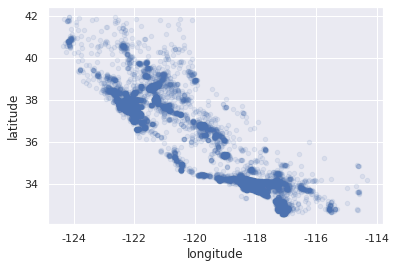

In [ ]:
#밀집된 영역 보이기
ax = strat_train_set.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
ax.set(xlabel='longitude', ylabel='latitude')

[Text(0, 0.5, '위도'), Text(0.5, 0, '경도')]

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44221 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50948 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 50948 missing from current font.
  font.set_text

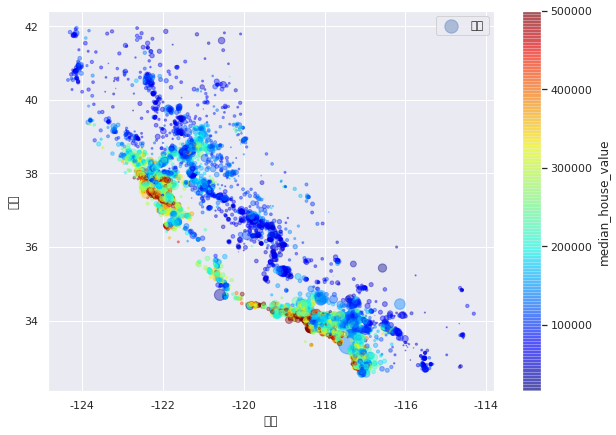

In [ ]:
#주택 가격 나타내기 
ax = strat_train_set.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=strat_train_set["population"]/100, label="인구", figsize=(10,7), #원 반지름 #구역의 인구
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True, #가격
    sharex=False)
ax.set(xlabel='경도', ylabel='위도')
plt.legend()

- 해안 지역에 주택 가격 높게 책정
- 인구 밀도 높을수록 주택 가격 높음

### 3. 상관 관계 확인

In [ ]:
#피어슨 상관 계수
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.050594
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

시각적으로 확인

' Function to plot correlation of features '

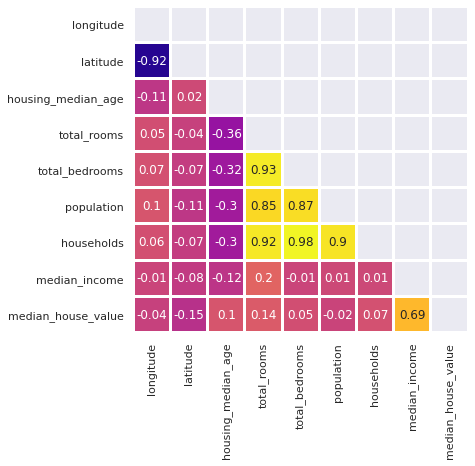

In [ ]:
''' Function to plot correlation of features '''
def corrMat(df,id=False):
    
    corr_mat = df.corr().round(2)
    f, ax = plt.subplots(figsize=(6,6))
    mask = np.zeros_like(corr_mat,dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr_mat,mask=mask,vmin=-1,vmax=1,center=0, 
                cmap='plasma',square=False,lw=2,annot=True,cbar=False);plt.show()

corrMat(strat_train_set)

Target variable median_house_value is very mildly correlated to all but one feature here: median_income.

`so "median income" might outline this as an important feature.`

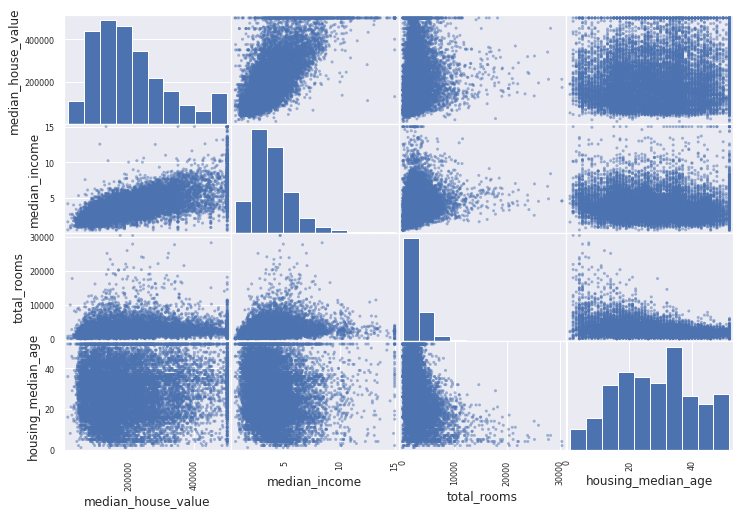

In [ ]:
#상관 관계 높은 top3개의 변수에 대하여 plot
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(strat_train_set[attributes], figsize=(12, 8));

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


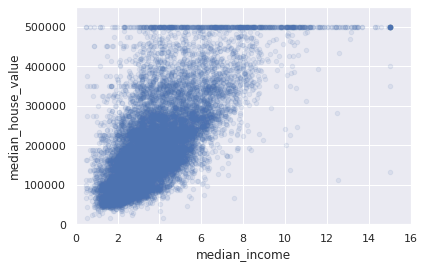

In [ ]:
#가장 큰 상관관계를 보인 median_housing_value와 median_income 간 plot
strat_train_set.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000]);

In [ ]:
''' Draw a Bivariate Seaborn Pairgrid /w KDE density w/ '''
def snsPairGrid(df):

    ''' Plots a Seaborn Pairgrid w/ KDE & scatter plot of df features'''
    g = sns.PairGrid(strat_train_set,diag_sharey=False)
    g.fig.set_size_inches(14,13)
    g.map_diag(sns.kdeplot, lw=2) # draw kde approximation on the diagonal
    g.map_lower(sns.scatterplot,s=15,edgecolor="k",linewidth=1,alpha=0.4) # scattered plot on lower half
    g.map_lower(sns.kdeplot,cmap='plasma',n_levels=10) # kde approximation on lower half
    plt.tight_layout()

' Draw a Bivariate Seaborn Pairgrid /w KDE density w/ '

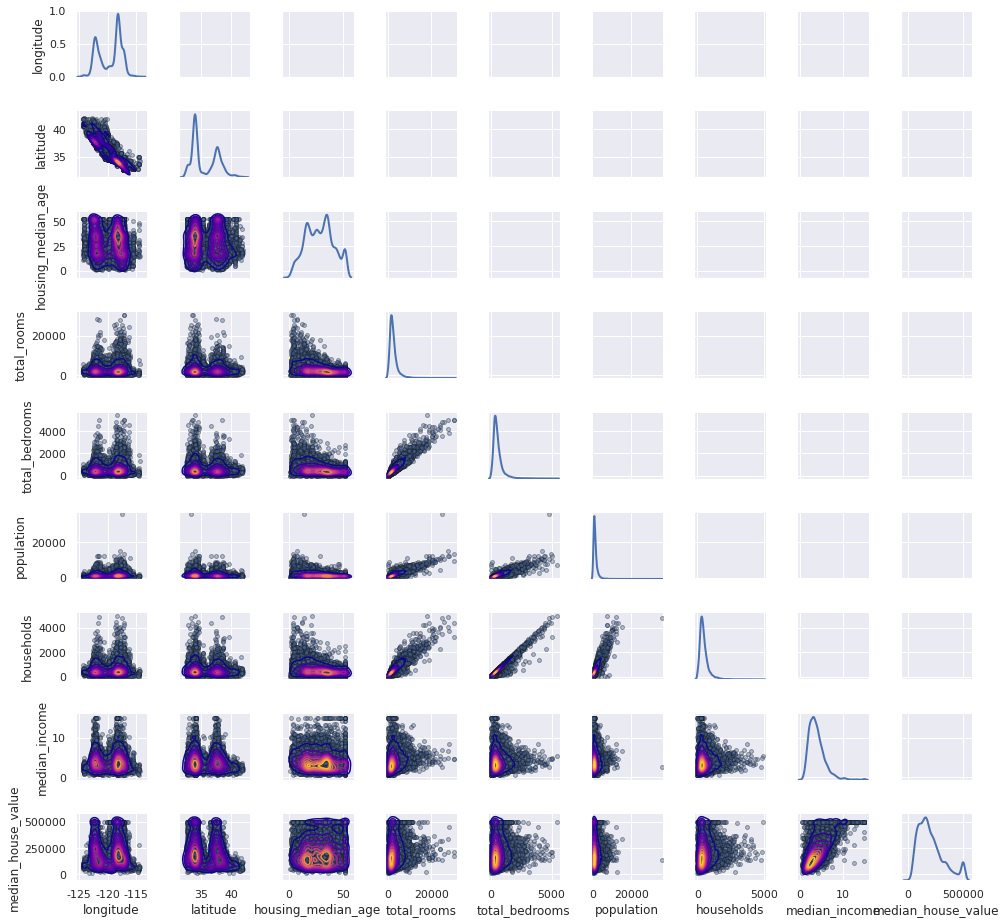

In [ ]:
tlist = ['median_income','total_rooms','housing_median_age','latitude','median_house_value','population']
snsPairGrid(strat_train_set[tlist]) 

#### outlier 제거

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f77dfa19e90>,
      dtype=object)

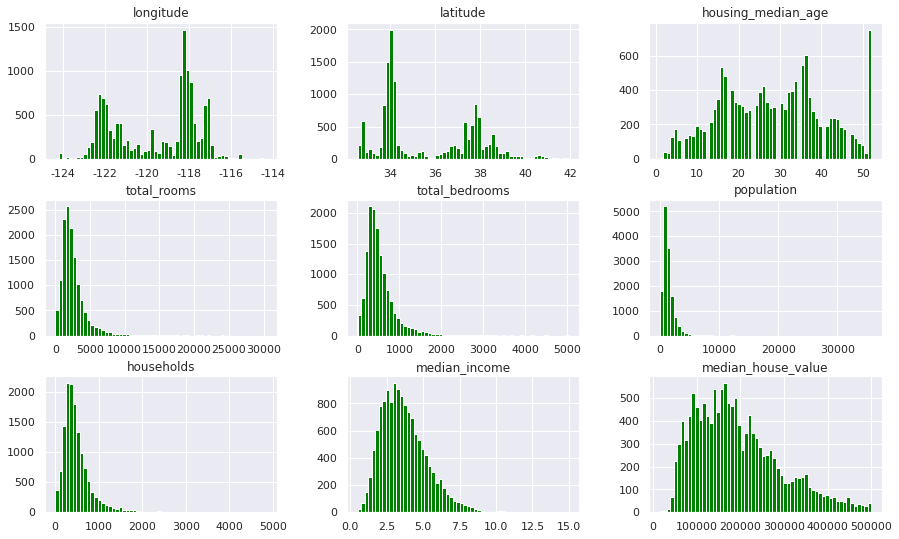

In [ ]:
# train_data_update : training data w/ removed outliers
#data를 살펴볼 때 있었던 outlier 제거
maxval2 = strat_train_set['median_house_value'].max() # get the maximum value
train_set = strat_train_set[strat_train_set['median_house_value'] != maxval2] 
test_set = strat_test_set[strat_test_set['median_house_value'] != maxval2]
train_set.hist(bins=60, figsize=(15,9),color="green"); plt.show() # looks like its completely removed.

#### scaling

In [ ]:
#표준화를 위한 변환기
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
housing_array = scaler.fit_transform(train_set) #스케일링 결과는 array로 변환
housing_prepared=pd.DataFrame(housing_array,) #dataframe 형태로
housing_prepared.columns=["longitude","latitude","housing_median_age","total_rooms","total_bedrooms",
                             "population","households","median_income","median_house_value"] 
housing_prepared.head(3)
print('housing_prepared.shape :', housing_prepared.shape)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-0.880498,1.087081,1.173219,-0.077820,-0.119570,-0.307525,-0.166572,-0.487077,-1.065263
1,-0.860529,1.460230,-1.785434,0.557743,0.023089,0.262096,0.224599,1.392051,0.082698
2,-1.569432,1.567510,-0.825871,-0.850173,-0.932721,-1.108527,-1.161564,-0.866698,-0.313889


housing_prepared.shape : (13792, 9)


# 4. Feature engineering


### variable combination

In [ ]:
#단순 방의 개수는 유의 x #가구당 방의 개수
housing_prepared['rooms_per_household'] = housing_prepared['total_rooms'] / housing_prepared['households']
#마찬가지로 단순 침실 개수도 유의하지 않을 것
housing_prepared['bedrooms_per_room'] = housing_prepared['total_bedrooms'] / housing_prepared['total_rooms']
#가구당 인원
housing_prepared['population_per_household'] = housing_prepared['population'] / housing_prepared['households']

housing_prepared

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
0,-0.880498,1.087081,1.173219,-0.077820,-0.119570,-0.307525,-0.166572,-0.487077,-1.065263,0.467184,1.536495,1.846197
1,-0.860529,1.460230,-1.785434,0.557743,0.023089,0.262096,0.224599,1.392051,0.082698,2.483284,0.041396,1.166951
2,-1.569432,1.567510,-0.825871,-0.850173,-0.932721,-1.108527,-1.161564,-0.866698,-0.313889,0.731921,1.097096,0.954339
3,-1.284872,0.970472,1.333146,-0.142027,-0.212298,-0.384357,-0.150820,-0.097874,-0.072267,0.941701,1.494764,2.548449
4,-1.244934,0.657959,1.013292,-0.092243,-0.091038,-0.464723,-0.355594,0.310748,0.081678,0.259406,0.986934,1.306890
...,...,...,...,...,...,...,...,...,...,...,...,...
13787,-0.461148,1.931330,-1.385616,-0.980450,-1.037337,-1.092630,-1.090681,-0.827035,-0.951079,0.898934,1.058022,1.001787
13788,0.786920,-0.750678,-0.585980,-0.848312,-0.899435,-0.845353,-0.880656,-0.668384,-0.022311,0.963273,1.060264,0.959913
13789,-1.200004,1.268991,-1.385616,0.273462,0.593721,0.292123,0.505507,-0.593247,0.260091,0.540965,2.171133,0.577880
13790,-1.424656,0.989129,1.892891,-0.990221,-0.954120,-0.993719,-0.875406,-0.375514,0.323301,1.131156,0.963543,1.135153


In [ ]:
corr_matrix = housing_prepared.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.642774
total_rooms                 0.146846
households                  0.097630
total_bedrooms              0.077431
housing_median_age          0.065833
population                  0.015036
bedrooms_per_room           0.010078
population_per_household    0.007122
rooms_per_household        -0.008491
longitude                  -0.046139
latitude                   -0.148183
Name: median_house_value, dtype: float64

In [ ]:
#관계가 없는 하위 4개의 변수 제거
del housing_prepared["rooms_per_household"]
del housing_prepared["population_per_household"]
del housing_prepared["bedrooms_per_room"]
del housing_prepared["latitude"]

# 5. model selection &training

## 1. linear regression

In [ ]:
from sklearn.linear_model import LinearRegression
housing_labels=housing_prepared["median_house_value"]
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print('RMSE :', lin_rmse)

RMSE : 9.63595342273402e-16


mse가 너무 크다-> underfitting: 더 복잡한 모델 시도

`K-fold cross validation` :모델 검증

In [ ]:
from sklearn.model_selection import cross_val_score

lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

def display_scores(scores):
    print("점수:", scores)
    print("평균:", scores.mean())
    print("표준편차:", scores.std())
display_scores(lin_rmse_scores)

점수: [6.18447211e-16 3.02132466e-16 7.14042763e-16 5.38134461e-16
 5.08031530e-16 5.23697924e-16 7.01685455e-16 7.25214042e-16
 4.34159364e-16 1.95074507e-15]
평균: 7.016290283097159e-16
표준편차: 4.353076975787349e-16


## 2. Decisinotree regression



In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print('RMSE :', tree_rmse)

RMSE : 6.300291926394252e-05


In [ ]:
# DecisionTree
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

점수: [0.00106349 0.0014073  0.00118576 0.00081053 0.00108096 0.00099087
 0.00225672 0.00114549 0.00136146 0.00115732]
평균: 0.001245989781783074
표준편차: 0.00037386736669811415


## 3. Randomforest regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(housing_prepared, housing_labels)


housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

RMSE : 0.0003193494262884035


In [ ]:
#Randomforest regression
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

점수: [0.0013277  0.00065936 0.00084465 0.00049089 0.00064984 0.00054029
 0.00173316 0.00115551 0.0005461  0.00078885]
평균: 0.0008736336706652882
표준편차: 0.0003864351938808396


In [ ]:
print('RMSE :', forest_rmse)

RMSE : 0.0003193494262884035


quite good model 

참고 
- Hanson machine learing
- https://www.kaggle.com/shtrausslearning/house-price-prediction-using-bayesian-regression